In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1629
            Open  High   Low  Close   Volume Ticker
Time                                               
2017-06-02  3230  3330  3200   3280   411631    VND
2017-06-05  3320  3370  3270   3280   671582    VND
2017-06-06  3280  3320  3270   3320   174560    VND
2017-06-07  3320  3610  3320   3590  2332950    VND
2017-06-08  3640  3640  3510   3540   467477    VND
2017-06-09  3520  3660  3520   3560   726174    VND


<Axes: xlabel='Time'>

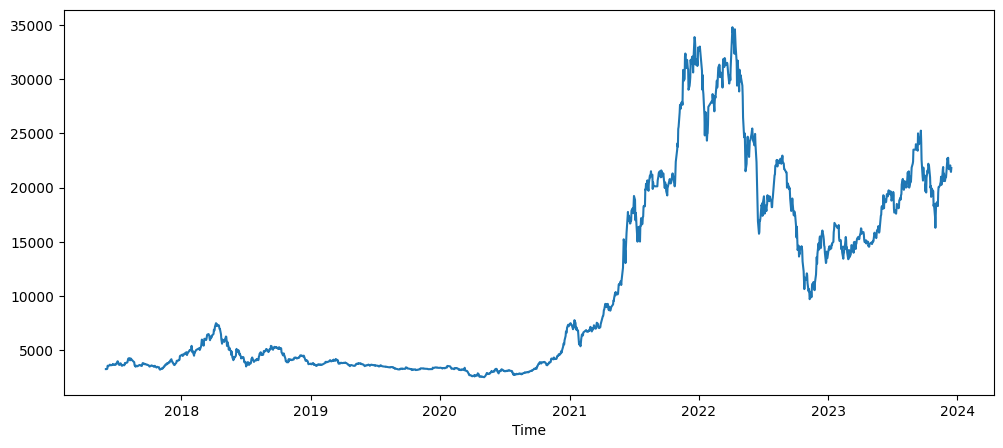

In [3]:
# Import data
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
print(pd.DataFrame(VND.head(6)))
train_dates = VND.index
plt.figure(figsize=(12, 5))
VND["Close"].plot()

In [4]:
VND = VND.reset_index(drop = True)
df = VND['Close']
df

0        3280
1        3280
2        3320
3        3590
4        3540
        ...  
1624    21950
1625    22050
1626    21600
1627    21450
1628    21800
Name: Close, Length: 1629, dtype: int64

In [5]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [6]:
from PyEMD import EMD, CEEMDAN

In [7]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [8]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7
0,-48.732555,-57.219547,-60.773446,-76.487141,53.644337,-648.323439,4117.891791
1,-29.061728,-73.236982,-68.280091,-77.608478,70.049237,-656.770464,4114.908506
2,-62.487163,-28.052329,-51.022802,-72.521177,87.082887,-664.934797,4111.935382
3,84.423662,45.226401,-18.272482,-62.234325,104.696248,-672.811902,4108.972398
4,-23.079834,45.088051,17.636782,-48.102036,122.834742,-680.397241,4106.019536
...,...,...,...,...,...,...,...
1624,160.078058,-506.804189,-48.910684,2986.704941,-2264.841692,4277.304211,17346.469355
1625,290.580816,-464.261993,-124.945050,2997.996101,-2263.593721,4270.155320,17344.068529
1626,-170.266911,-401.114833,-146.771586,2972.853769,-2259.333303,4262.869624,17341.763240
1627,-327.964261,-371.386001,-103.495601,2909.964614,-2252.128743,4255.456763,17339.553229


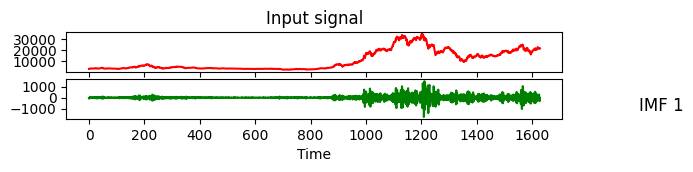

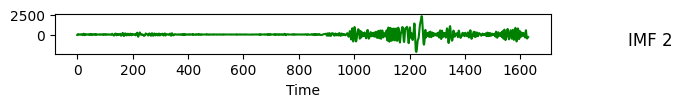

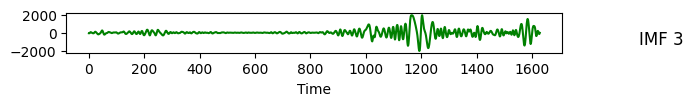

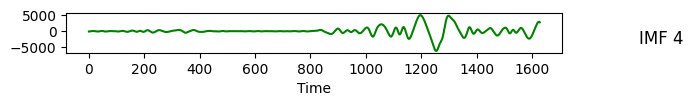

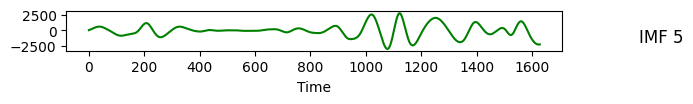

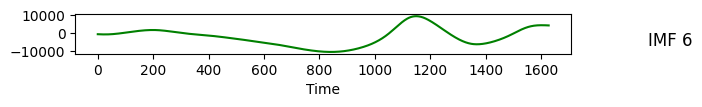

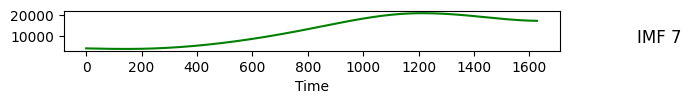

In [9]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [10]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1629, 1)
Residue: (1629, 1)


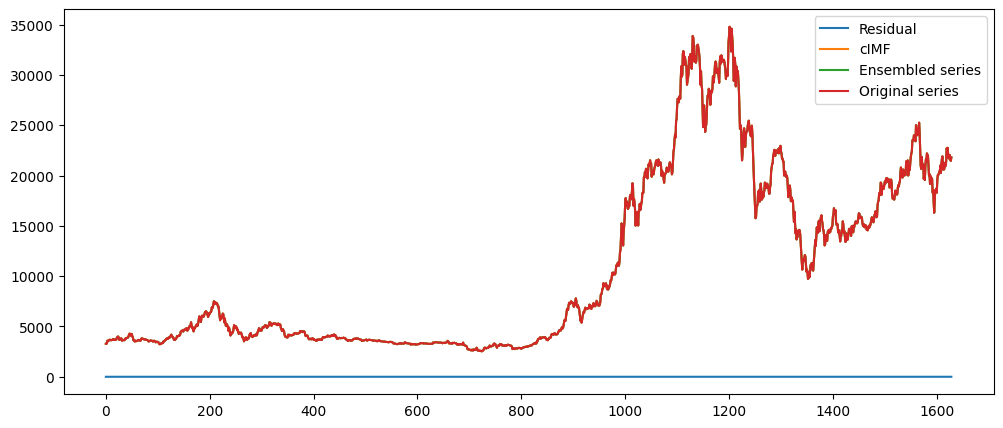

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [12]:
# (B) LSTM
## 0. Prepocessing
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [13]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF

array([[ 3280.],
       [ 3280.],
       [ 3320.],
       ...,
       [21600.],
       [21450.],
       [21800.]])

In [14]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1629, 1)
Train:  (1303, 1)
Test:  (326, 1)


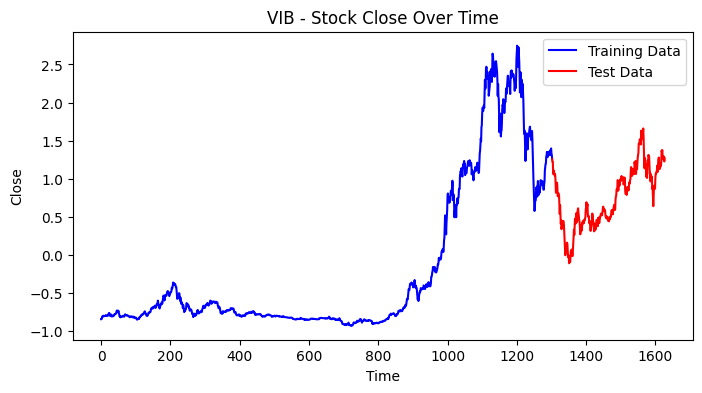

In [15]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.8*IMFscale.shape[0])
test_size = int(0.2*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [16]:
trainX = []
trainY = []

n_past = 60
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (1243, 60, 1)
Y train:  (1243, 1)


In [17]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (266, 60, 1)
Y test:  (266, 1)


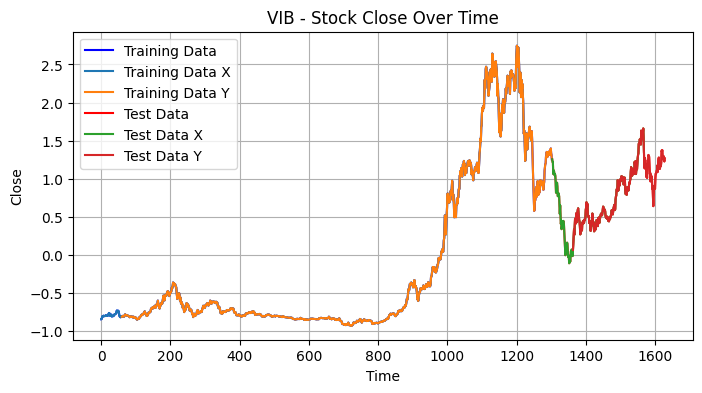

In [18]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
## 1. Train model
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=10, validation_split=0.1, verbose=1)

Epoch 1/100
112/112 [==============================] - 9s 53ms/step - loss: 36.8141 - val_loss: 16.2102
Epoch 2/100
112/112 [==============================] - 4s 39ms/step - loss: 24.6295 - val_loss: 12.8977
Epoch 3/100
112/112 [==============================] - 5s 48ms/step - loss: 19.2211 - val_loss: 13.0655
Epoch 4/100
112/112 [==============================] - 5s 43ms/step - loss: 20.4869 - val_loss: 13.3358
Epoch 5/100
112/112 [==============================] - 4s 39ms/step - loss: 18.1826 - val_loss: 15.1406
Epoch 6/100
112/112 [==============================] - 6s 53ms/step - loss: 17.7299 - val_loss: 13.8129
Epoch 7/100
112/112 [==============================] - 4s 39ms/step - loss: 16.3629 - val_loss: 10.9392
Epoch 8/100
112/112 [==============================] - 4s 39ms/step - loss: 18.0053 - val_loss: 10.6715
Epoch 9/100
112/112 [==============================] - 6s 54ms/step - loss: 16.9053 - val_loss: 10.0630
Epoch 10/100
112/112 [==============================] - 4s 39ms/

In [21]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

9/9 [==============================] - 0s 15ms/step
[11066.204  11144.345  11490.037  12064.745  12806.537  12998.161
 13476.478  14217.427  14319.189  14353.524  14884.663  15254.904
 14853.538  15204.678  15443.503  15733.809  15944.896  15698.239
 15426.496  15005.456  14764.245  14377.404  13772.848  13481.723
 13693.499  13919.395  13768.651  13677.596  14052.405  14243.13
 14470.715  14423.167  14441.997  14444.744  14626.687  14691.352
 14829.708  14947.733  15518.183  15923.822  16477.494  16384.541
 16321.4795 16476.723  15834.233  15424.041  15241.12   15194.148
 14757.881  14686.808  14552.378  14294.393  13906.306  13909.384
 13972.59   14318.271  14428.788  15024.042  15135.196  14734.077
 14633.993  14325.252  13892.435  13685.536  13958.545  13961.598
 13824.778  13861.595  14053.45   14417.486  14607.372  14591.033
 14573.465  14306.175  14653.688  14754.225  14916.822  14646.4795
 14747.143  14819.99   15023.258  15203.305  15370.584  15327.353
 15362.163  15316.203  1

In [22]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

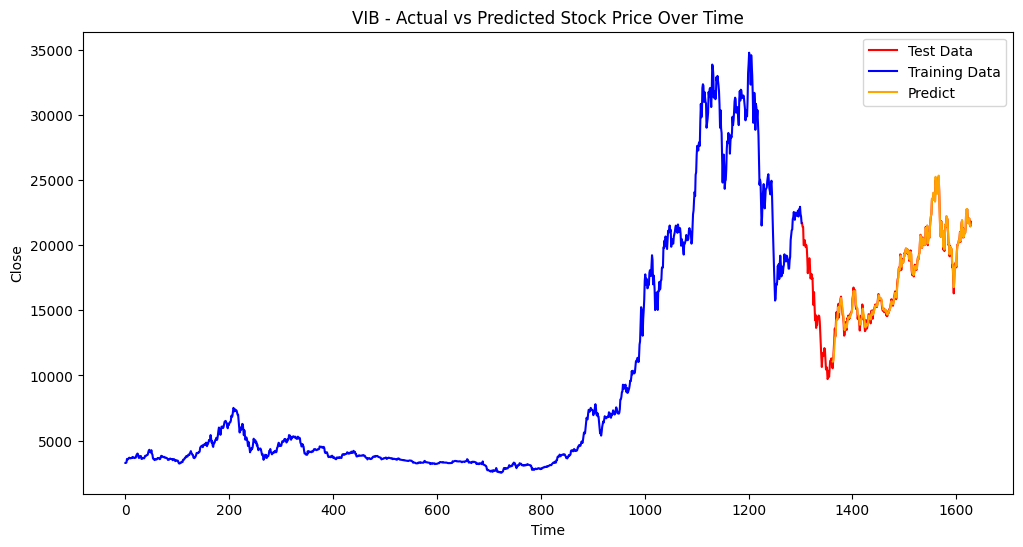

In [23]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_past-1, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-60):])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(327, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(328, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(329, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(330, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(331, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 29ms/step
(332, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(333, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(334, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(335, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 29ms/step
(336, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(337, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(338, 1)
(60, 1)
(1, 60, 1)
1/1 [================

In [25]:
print(y_forecast)

[[21799.19 ]
 [21809.797]
 [21825.186]
 [21836.932]
 [21846.158]
 [21853.855]
 [21860.734]
 [21867.248]
 [21873.648]
 [21880.053]
 [21886.502]
 [21893.   ]
 [21899.533]
 [21906.086]
 [21912.643]
 [21919.191]
 [21925.725]
 [21932.24 ]
 [21938.734]
 [21945.205]
 [21951.648]
 [21958.068]
 [21964.463]
 [21970.834]
 [21977.176]
 [21983.494]
 [21989.79 ]
 [21996.057]
 [22002.297]
 [22008.514]
 [22014.705]
 [22020.87 ]
 [22027.01 ]
 [22033.123]
 [22039.213]
 [22045.273]
 [22051.314]
 [22057.326]
 [22063.312]
 [22069.275]
 [22075.213]
 [22081.121]
 [22087.006]
 [22092.867]
 [22098.701]
 [22104.51 ]
 [22110.291]
 [22116.05 ]
 [22121.783]
 [22127.49 ]
 [22133.174]
 [22138.83 ]
 [22144.46 ]
 [22150.07 ]
 [22155.65 ]
 [22161.207]
 [22166.74 ]
 [22172.248]
 [22177.729]
 [22183.184]]


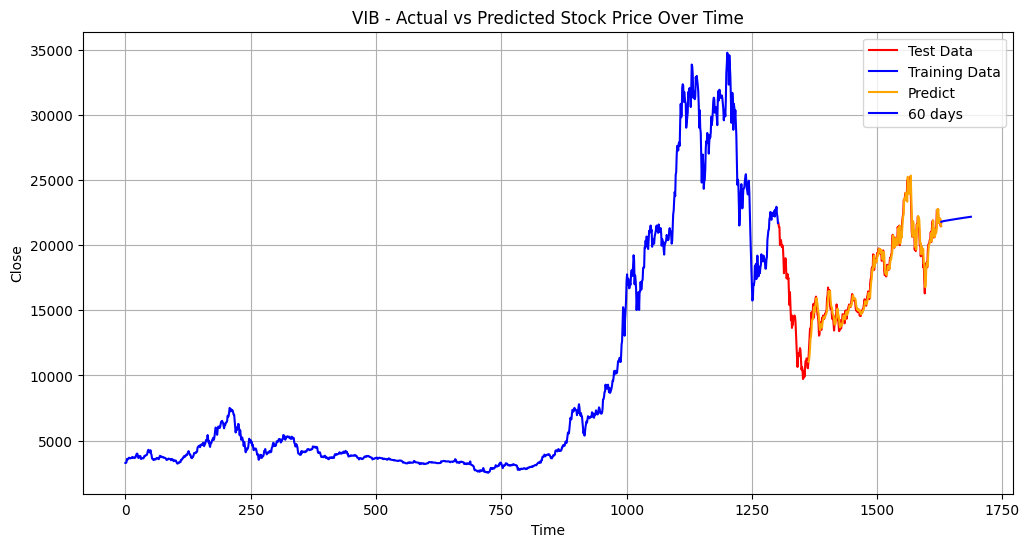

In [26]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size + 60, train_size + test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100

In [28]:
size = -1*test_size+60
print("RSME: ", RSME(y_pred_future, test_back[60:]))
print("MAE: ", MAE(y_pred_future, test_back[60:]))
print("MAPE: ", MAPE(y_pred_future, test_back[60:]))

RSME:  4464.60938684872
MAE:  3588.343697663449
MAPE:  20.52579182808343


In [29]:
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("MSLR: ", MSLE(y_pred_future, test_back[14:]))

MSLR:  0.07700576795485214
